## Import packages

In [1]:
import sys
sys.path.append('../scripts')

import argparse
import gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.models.callbacks import PerplexityMetric
from gensim.models.wrappers import LdaMallet
import glob
import lxml.etree
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-whitegrid')

from utils import is_punct

TOKENIZER = nltk.tokenize.word_tokenize

In [2]:
import logging

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

## Corpus characteristics

In [ ]:
nlb = pd.read_csv('../data/nlb.csv', sep=',')
nlb.shape

## Preprocessing of the corpus for topic modeling

In [ ]:
CORPUS_PATH = '../corpus/VARDnormalized/*.txt'
stop_words_path = '../stoplist/stoplist_VARD2.txt'
stop_words = [s.lower() for s in open(stop_words_path, 'r', encoding='utf-8').read().splitlines()]

NO_BELOW = 2 #minimum document frequency
NO_ABOVE = 1 #maximum document frequency

N_TOPICS = 50
ITERATIONS = 2000
OPTIMIZE_INTERVAL = 20 # 20 originally
EVAL_EVERY = 3 # for regular LDA 
N_WORKERS = 3 # number of CPU'S for multiprocessing # 3 originally

In [ ]:
remove_stopwords = lambda x: [word.lower() for word in x if word.lower() not in stop_words and not is_punct(word) and len(word) > 1]

texts = glob.glob(CORPUS_PATH, recursive=False)
tokenized_texts = [TOKENIZER(open(text, "r", encoding="utf-8").read(), language="dutch") for text in texts]
tokenized_texts = [remove_stopwords(text) for text in tokenized_texts]

In [ ]:
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

## Setting parameters for topic modeling

In [ ]:
from gensim.models import CoherenceModel

In [ ]:
# Compute Coherence score for a model
coherence_model_ldamallet = CoherenceModel(model=lda, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

In [ ]:
#compute coherence score for various number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet('[PATH-TO]/mallet-2.0-4.8/bin/mallet', corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=ITERATIONS,  
                workers=N_WORKERS, optimize_interval=OPTIMIZE_INTERVAL)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_texts, start=10, limit=110, step=10)

In [ ]:
# Show graph
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

limit=80; start=20; step=10;
x = range(start, limit, step)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.plot(x, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence score")
#plt.legend(("coherence_values"), loc='best')
#plt.savefig('coherence_values_2_20_70_EMLC.jpg',dpi=300)

## Build topic model from VARD2-normalized corpus...

In [ ]:
lda = LdaMallet('[PATH-TO]/mallet-2.0-4.8/bin/mallet', 
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS, 
                iterations=ITERATIONS,  
                workers=N_WORKERS,
                optimize_interval=OPTIMIZE_INTERVAL)

## ...or load existing model

In [ ]:
lda = LdaMallet.load('../topic_models/VARD2-TM')

## Save the model

In [ ]:
lda.save('VARD2-TM-EMLC')

## Analyze the model

In [ ]:
rows = []
for topic in range(0, 50):
    words = lda.show_topic(topic)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))
    rows.append([str(topic), topic_n_words])
keys = pd.DataFrame(rows, columns=['topic', 'words'])

In [ ]:
keys.to_csv('VARD2_keys_EMLC.csv', sep='\t')

In [ ]:
transformed_docs = lda.load_document_topics()
docs = [[texts[indx]] + [p[1] for p in doc] for indx, doc in enumerate(transformed_docs)]
composition = pd.DataFrame(docs, columns=['document_id'] + ['topic {}'.format(x) for x in range(0, 50)])

In [ ]:
composition[['path', 'songid']] = composition.document_id.str.split('varded50/', expand=True)
composition = composition.drop(columns=['document_id', 'path'])
composition[['id', 'txt']] = composition.songid.str.split('.', expand=True)
composition = composition.drop(columns=['songid', 'txt'])

In [ ]:
col_names = ([f'topic {i}' for i in range(0, 50)])
col_names.insert(0, 'id')
composition = composition[col_names]

In [ ]:
composition.to_csv('VARD2_topics_EMLC.csv', sep='\t')

In [ ]:
composition = pd.read_csv('VARD2_topics_EMLC.csv', sep='\t', index_col='id').drop(columns=['Unnamed: 0'])
composition.head()

## Choose topic with highest contribution for each song

In [ ]:
transformed_docs = lda.load_document_topics()
docs = [[texts[i]] + [r[0] for r in list(zip(max(row, key=lambda x:x[1])))] for i, row in enumerate(transformed_docs)]
dominant_topics = pd.DataFrame(docs, columns=['document_id', 'dominant_topic', 'perc_contribution'])

dominant_topics[['path', 'songid']] = dominant_topics.document_id.str.split('varded50/', expand=True)
dominant_topics = dominant_topics.drop(columns=['document_id', 'path'])
dominant_topics[['id', 'txt']] = dominant_topics.songid.str.split('.', expand=True)
dominant_topics = dominant_topics.drop(columns=['songid', 'txt'])
dominant_topics = dominant_topics[['id','dominant_topic','perc_contribution']]
#dominant_topics.to_csv('VARD2_dominant_topic_per_song_EMLC.csv', sep='\t')

## Count how many times a topic appears as most dominant topic of a song

In [ ]:
topic_counts = dominant_topics["dominant_topic"].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
df_dominant_topics = pd.concat([topic_counts, topic_contribution],axis=1)
df_dominant_topics.columns = ["Num_Documents", "Perc_Documents"]

## Choose songs which represent a topic at best

In [ ]:
song_topic_highest_contribution = pd.DataFrame()
song_topics_outdf_grpd = dominant_topics.groupby("dominant_topic")

for i, grp in song_topics_outdf_grpd:
    song_topic_highest_contribution = pd.concat([song_topic_highest_contribution,grp.sort_values(["perc_contribution"], ascending=[0]).head(1)],axis=0)

In [ ]:
song_topic_highest_contribution.reset_index(drop=True,inplace=True)
song_topic_highest_contribution.columns = ["id", "topic", "perc_contribution"]

## Extract the top3 dominant topics for each song

In [ ]:
x = pd.DataFrame(composition).T

In [ ]:
rslt = pd.DataFrame(np.zeros((0,3)), columns=['top1','top2','top3'])
for i in x.columns:
    df1row = pd.DataFrame(x.nlargest(3, i).index.tolist(), index=['top1','top2','top3']).T
    rslt = pd.concat([rslt, df1row], axis=0)

In [ ]:
arr = np.argsort(-composition.values, axis=1)
df1 = pd.DataFrame(composition.columns[arr], index=composition.index)

In [ ]:
top3topics = df1[[0, 1, 2]].copy()

## Extend corpus with songs with the same incnormid

In [ ]:
nlb = pd.read_csv('../data/nlb.csv', sep=',')
nlb_timeset = nlb[(nlb['jaar_begin'] >= 1550) & (nlb['jaar_begin'] <= 1750)]
nlb_timeset = nlb_timeset[nlb_timeset['incnormid'] != 0]

In [ ]:
topics = pd.read_csv('../gensim_output/VARD2_dominant_topic_per_song.csv', sep='\t', index_col=0)

In [ ]:
msc = nlb_timeset.merge(topics, left_on='recordid', right_on='id')

In [ ]:
nlb_timeset = nlb_timeset.loc[nlb_timeset['incnormid'].isin(msc['incnormid'])]

In [ ]:
incs = msc.groupby('incnormid').first()[['dominant_topic', 'perc_contribution']]

In [ ]:
topics = nlb_timeset.set_index('incnormid').join(incs).sort_values('incnormid')
topics = topics.reset_index()

# Roles of literature

In [13]:
df = pd.read_csv('../gensim_output/top3topics_allsongs.csv', sep='\t', index_col=0)

## Literature and ideology

In [14]:
df['top1'] = df['top1'].replace('topic 0', 'religion and life (0)')
df['top1'] = df['top1'].replace('topic 13', 'religion (13)')
df['top1'] = df['top1'].replace('topic 18', 'religion (18)')
df['top1'] = df['top1'].replace('topic 28', 'prayer and preaching (28)')
df['top1'] = df['top1'].replace('topic 31', 'religion (31)')

In [15]:
religion = ['religion and life (0)','religion (13)','religion (18)','prayer and preaching (28)','religion (31)']

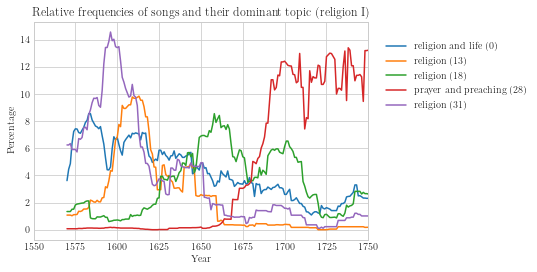

In [17]:
fig2 = pd.crosstab(df.year, df.top1, normalize='index').rolling(window=20).mean()[religion].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (religion I)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('religion_normalized_index.jpg', bbox_inches='tight', dpi=300)

In [18]:
df['top1'] = df['top1'].replace('topic 1', 'religion and Mary (1)')
df['top1'] = df['top1'].replace('topic 44', 'religion and virtue (44)')
df['top1'] = df['top1'].replace('topic 40', 'religion and Jesus (40)')
df['top1'] = df['top1'].replace('topic 4', 'religion and happiness (4)')
df['top1'] = df['top1'].replace('topic 42', 'cross and passion (42)')
df['top1'] = df['top1'].replace('topic 15', 'Old Testament (15)')

In [19]:
religion2  = ['religion and Mary (1)','religion and virtue (44)','religion and Jesus (40)','religion and happiness (4)','cross and passion (42)','Old Testament (15)']

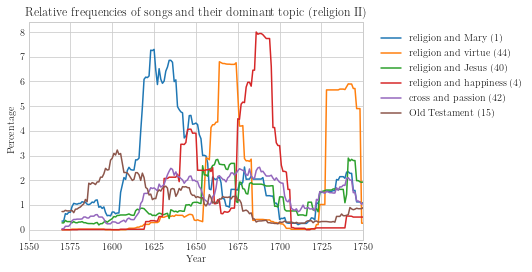

In [21]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[religion2].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (religion II)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('religion2_normalized_index.jpg', bbox_inches='tight',dpi=300)

## Literature and poetics

In [22]:
df['top1'] = df['top1'].replace('topic 38', 'love and happiness (38)')
df['top1'] = df['top1'].replace('topic 39', 'love and sadness (39)')

In [23]:
love = ['love and happiness (38)','love and sadness (39)']

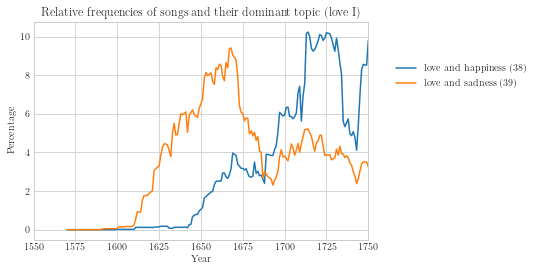

In [25]:
fig1 = pd.crosstab(df.year, df.top1, normalize='index').rolling(window=20).mean()[love].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (love I)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('love_normalized_index.jpg', bbox_inches='tight',dpi=300)

In [26]:
df['top1'] = df['top1'].replace('topic 38', 'love and happiness (38)')
df['top1'] = df['top1'].replace('topic 39', 'love and sadness (39)')
df['top1'] = df['top1'].replace('topic 2', 'love and tragedy (2)')
df['top1'] = df['top1'].replace('topic 24', 'rejection (24)')
df['top1'] = df['top1'].replace('topic 34', 'seducing (34)')
df['top1'] = df['top1'].replace('topic 21', 'love and happiness (21)')
df['top1'] = df['top1'].replace('topic 23', 'physical love (23)')

In [27]:
love_extended = ['love and happiness (38)','love and sadness (39)','love and tragedy (2)','rejection (24)','seducing (34)','love and happiness (21)','physical love (23)']

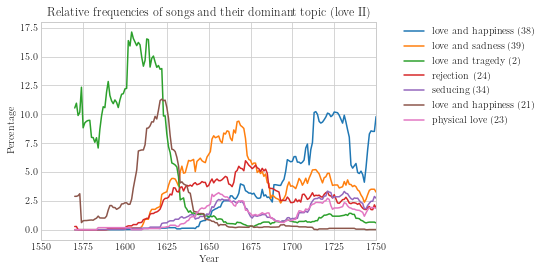

In [29]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[love_extended].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (love II)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('love_extended_normalized_index.jpg', bbox_inches='tight',dpi=300)

In [30]:
df['top1'] = df['top1'].replace('topic 47', 'bucolic songs (47)')
df['top1'] = df['top1'].replace('topic 14', 'myth and beauty (14)')
df['top1'] = df['top1'].replace('topic 37', 'nature (37)')

In [31]:
bucolic = ['bucolic songs (47)','myth and beauty (14)','nature (37)']

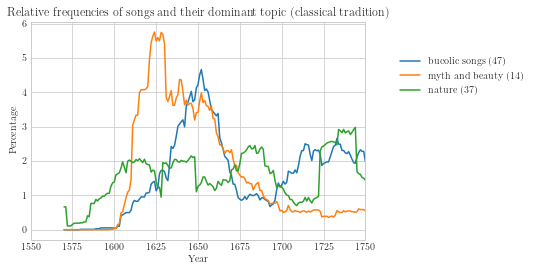

In [33]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[bucolic].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (classical tradition)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('bucolic_normalized.jpg', bbox_inches='tight',dpi=300)

## Literature and politics

In [34]:
df['top1'] = df['top1'].replace('topic 32', 'nation and country (32)')
df['top1'] = df['top1'].replace('topic 7', 'God and enemy (7)')
df['top1'] = df['top1'].replace('topic 49', 'God and country (49)')

In [35]:
nation = ['nation and country (32)','God and enemy (7)','God and country (49)']

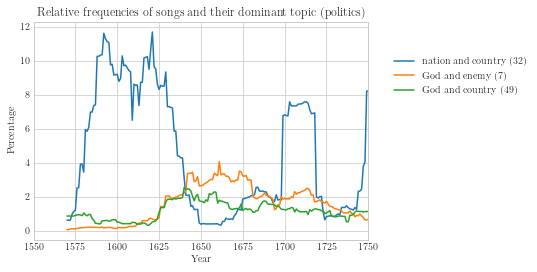

In [37]:
fig1 = pd.crosstab(df.year, df.top1,normalize='index').rolling(window=20).mean()[nation].mul(100).plot()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.legend(loc='right', bbox_to_anchor=(1.5, 0.75),
          ncol=1, fancybox=False, shadow=False)
plt.title('Relative frequencies of songs and their dominant topic (politics)')
plt.ylabel('Percentage')
plt.xlabel('Year')
plt.savefig('nation_normalized.jpg', bbox_inches='tight',dpi=300)